<a href="https://colab.research.google.com/github/daham-13/CM2604-Coursework/blob/main/FeatherFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy
from spacy.matcher import Matcher
from spacy.util import filter_spans
from spacy.tokens import Span

class FeatureExtractor:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")

        # Expanded color synonyms
        self.COLOR_SYNONYMS = {
            "azure": "blue", "crimson": "red", "scarlet": "red",
            "emerald": "green", "ivory": "white", "charcoal": "black",
            "golden": "yellow", "amber": "yellow", "sandy": "brown",
            "lavender": "purple", "grey": "gray", "turquoise": "blue",
            "magenta": "pink", "coral": "orange", "teal": "green",
            "maroon": "red", "burgundy": "red", "indigo": "blue"
        }

        # Expanded habitat terms
        self.HABITAT_TERMS = [
            "forest", "jungle", "wetland", "desert", "water", "mountains",
            "grassland", "marsh", "coast", "field", "woodland", "garden",
            "savanna", "river", "rainforest", "marshlands", "highlands", "lake",
            "scrubland", "prairies", "tundra", "alpine", "mangroves", "ocean",
            "outback", "grove", "orchard", "valley", "waterfall", "pond", "city", "suburban", "urban"
        ]

        # Expanded size terms
        self.SIZE_TERMS = ["small", "large", "tiny", "big", "medium", "giant", "massive", "huge", "curved", "spare", "long", "short", "thick", "hooked", "slender", "broad", "muscular"]

        self.CONTINENTS = ["asia", "europe", "africa", "america", "australia", "antarctica"]
        self.DIRECTIONS = ["north", "south", "east", "west", "central"]

        # Expanded beak shapes
        self.BEAK_SHAPES = ["curved", "spare", "long", "short", "thick", "hooked", "slender", "broad"]

    def extractFeatures(self, text):
        doc = self.nlp(text.lower())
        features = {
            "size": None,
            "color": {"primary": None, "secondary": None},
            "habitat": None,
            "region": None,
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None},
        }

        # Extract size and color features
        for token in doc:
            if token.dep_ == "amod" and token.head.text in ["bird", "body"] and token.text in self.SIZE_TERMS:
                features["size"] = token.text  # Store the size term

            # Color detection on feathers/body parts
            if token.dep_ == "amod" and token.head.text in ["feathers", "wings", "chest", "body", "plumage", "tail"]:
                if token.text not in self.SIZE_TERMS:  # Ensure it's not a size term
                    compound_color = None
                    for child in token.head.children:
                        if child.dep_ == "compound":
                            compound_color = self.COLOR_SYNONYMS.get(child.text, child.text)
                            break
                    color = compound_color if compound_color else self.COLOR_SYNONYMS.get(token.text, token.text)

                    # Assign colors correctly
                    if not features["color"]["primary"]:
                        features["color"]["primary"] = color
                    elif not features["color"]["secondary"] and color != features["color"]["primary"]:
                        features["color"]["secondary"] = color

                    # Handle conjunctions (e.g., "blue and green feathers")
                    for conj in token.conjuncts:
                        conj_color = self.COLOR_SYNONYMS.get(conj.text, conj.text)
                        if conj_color != features["color"]["primary"] and not features["color"]["secondary"]:
                            features["color"]["secondary"] = conj_color

            # Direct color modifiers on bird and body
            if token.dep_ == "amod" and token.head.text in ["bird", "body","feathers", "wings", "chest", "body", "plumage", "tail"]:
                if token.text not in self.SIZE_TERMS:  # Ensure it's not a size term
                    color = self.COLOR_SYNONYMS.get(token.text, token.text)

                    # Assign colors correctly
                    if not features["color"]["primary"]:
                        features["color"]["primary"] = color
                    elif not features["color"]["secondary"] and color != features["color"]["primary"]:
                        features["color"]["secondary"] = color

                    # Handle conjunctions (e.g., "blue and green bird")
                    for conj in token.conjuncts:
                        conj_color = self.COLOR_SYNONYMS.get(conj.text, conj.text)
                        if conj_color != features["color"]["primary"] and not features["color"]["secondary"]:
                            features["color"]["secondary"] = conj_color

            # Body part feature extraction
            if token.text in ["eyes", "beak", "bill", "legs"]:
                category = "beak" if token.text == "bill" else token.text
                adjectives = []

                # Direct modifiers and compounds
                for child in token.children:
                    if child.dep_ in ("amod", "compound"):
                        if child.text in self.COLOR_SYNONYMS:
                            adj = self.COLOR_SYNONYMS[child.text]
                            adjectives.append(adj)
                        elif child.text in self.SIZE_TERMS:
                            adjectives.append(child.text)

                # Conjunction handling (e.g., "small and black")
                adjectives = []  # Preserve order
                seen = set()  # Track unique adjectives to prevent duplicates

                for child in token.children:
                    if child.dep_ == "amod":
                        # Process the main adjective
                        adj_text = child.text.lower()
                        mapped_text = self.COLOR_SYNONYMS.get(adj_text, adj_text)  # Map colors

                        if mapped_text in self.SIZE_TERMS or mapped_text in self.COLOR_SYNONYMS.values() or mapped_text in self.BEAK_SHAPES:
                            if mapped_text not in seen:  # Avoid duplicates
                                adjectives.append(mapped_text)
                                seen.add(mapped_text)

                        # Process conjunctions
                        for conj in child.conjuncts:
                            conj_text = conj.text.lower()
                            mapped_conj_text = self.COLOR_SYNONYMS.get(conj_text, conj_text)

                            if mapped_conj_text in self.SIZE_TERMS or mapped_conj_text in self.COLOR_SYNONYMS.values() or self.BEAK_SHAPES:
                                if mapped_conj_text not in seen:
                                    adjectives.append(mapped_conj_text)
                                    seen.add(mapped_conj_text)  # Preserve unknown adjectives


                # Final assignment
                colors = [a for a in adjectives if a in self.COLOR_SYNONYMS.values()]
                sizes = [a for a in adjectives if a in self.SIZE_TERMS]

                if colors:
                    features[category]["color"] = colors[0] if len(colors) == 1 else colors
                if sizes:
                    features[category]["size"] = sizes[0] if len(sizes) == 1 else sizes

        # Initialize matcher
        matcher = Matcher(self.nlp.vocab)

        # Habitat pattern (now handles multi-word habitats)
        matcher.add("HABITAT", [
            [{"LOWER": {"IN": ["in", "near", "around", "along", "across"]}},
             {"IS_STOP": True, "OP": "*"},
             {"LOWER": {"IN": self.HABITAT_TERMS}}]
        ])

        # Region pattern (captures full region name)
        matcher.add("REGION", [
            [{"LOWER": {"IN": ["in", "from", "found", "of"]}},
             {"LOWER": {"IN": self.DIRECTIONS}, "OP": "*"},
             {"LOWER": {"IN": self.CONTINENTS}}]
        ])

        # Diet pattern
        matcher.add("DIET", [
            [{"LOWER": {"IN": ["eats", "feeds", "consumes", "diet", "hunts", "eating", "sipping", "preys"]}},
             {"IS_STOP": True, "OP": "*"},
             {"POS": {"IN": ["NOUN", "PROPN"]}}]
        ])

        # Physical characteristics pattern
        matcher.add("PHYSICAL_CHARACTERISTICS", [
            [{"POS": {"IN": ["ADV", "ADJ", "NUM"]}, "OP": "*"},
             {"POS": {"IN": ["ADJ", "NUM", "NOUN"]}, "OP": "+"},
             {"LOWER": {"IN": ["eyes", "beak", "bill", "legs"]}}]
        ])

        # Beak shape pattern
        matcher.add("BEAK_SHAPE", [
            [{"LOWER": {"IN": self.BEAK_SHAPES}},
             {"POS": {"IN": ["ADJ", "NUM", "NOUN"]}, "OP": "*"},
             {"LOWER": {"IN": ["beak", "bill"]}}],
            [{"POS": {"IN": ["ADJ", "NUM", "NOUN"]}, "OP": "*"},
             {"LOWER": {"IN": self.BEAK_SHAPES}},
             {"LOWER": {"IN": ["beak", "bill"]}}]
        ])

        # Match and process spans
        matches = matcher(doc)
        spans = []
        Span.set_extension("match_label", default=None, force=True)

        for match_id, start, end in matches:
            label = self.nlp.vocab.strings[match_id]
            span = doc[start:end]
            span._.match_label = label
            spans.append(span)

        filtered_spans = filter_spans(spans)

        for span in filtered_spans:
            label = span._.match_label
            if label == "HABITAT":
                features["habitat"] = span[-1].text  # Get last token of habitat span
            elif label == "REGION":
                # Join all tokens after preposition for full region name
                features["region"] = " ".join([token.text for token in span[1:]])
            elif label == "DIET":
                features["diet"] = span[-1].text
            elif label == "PHYSICAL_CHARACTERISTICS":
                category = span[-1].text
                category = "beak" if category == "bill" else category  # Handle "bill" as "beak"

                for token in span:
                    # Extract size terms
                    if token.text in self.SIZE_TERMS:
                        features[category]["size"] = token.text

                    # Extract colors (with synonyms)
                    elif token.text in self.COLOR_SYNONYMS:
                        features[category]["color"] = self.COLOR_SYNONYMS.get(token.text, token.text)

                    # Special handling for compound colors (e.g., "dark brown eyes")
                    elif token.dep_ == "amod" and token.head.text == category:
                        compound_color = None
                        for child in token.head.children:
                            if child.dep_ == "compound":
                                compound_color = self.COLOR_SYNONYMS.get(child.text, child.text)
                                break
                        color = compound_color if compound_color else self.COLOR_SYNONYMS.get(token.text, token.text)
                        features[category]["color"] = color

            elif label == "BEAK_SHAPE":
                category = "beak"
                for token in span:
                    if token.text in self.BEAK_SHAPES:
                        features[category]["size"] = token.text
                    elif token.text in self.COLOR_SYNONYMS:
                        features[category]["color"] = self.COLOR_SYNONYMS.get(token.text, token.text)

        return features

# Test 1: Simple color attribution
v =FeatureExtractor()
print(v.extractFeatures("A huge bird covered in brown feathers was sprinting across the field of Australia."))
# Output: 'beak': {'color': 'blue', 'size': 'long'}

{'size': 'huge', 'color': {'primary': 'brown', 'secondary': None}, 'habitat': 'field', 'region': 'australia', 'diet': None, 'eyes': {'size': None, 'color': None}, 'beak': {'size': None, 'color': None}, 'legs': {'size': None, 'color': None}}


In [ ]:
#Dataset

dataset = [
    #1
    {
        "prompt": "The small blue bird was found in forest and eats worms.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "worms",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #2
    {
        "prompt": "A crimson bird with green feathers was seen near wetland, and it feeds insects..",
        "expected_features": {
            "size": None,
            "color": {"primary": "red", "secondary": "green"},
            "habitat": "wetland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #3
    {
        "prompt": "A green bird and tiny beak was found in north america and consumes seeds.",
        "expected_features": {
            "size": None,
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "north america",
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "tiny", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #4
    {
        "prompt": "A big bird with white body and curved bill was spotted from east asia; it eats fish.",
        "expected_features": {
            "size": "big",
            "color": {"primary": "white", "secondary": None},
            "habitat": None,
            "region": "east asia",
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #5
    {
        "prompt": "a bird with blue and red body. tiny legs was found near the desert and feeds seeds.",
        "expected_features": {
            "size": None,  # 'large' modifies wings instead of bird directly
            "color": {"primary": "blue", "secondary": "red"},  # charcoal converts to black
            "habitat": "desert",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #6
    {
        "prompt": "The small blue bird was found in forest and eats worms.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "worms",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #7
    {
        "prompt": "A crimson bird with white feathers was seen near the wetland, and it feeds insects.",
        "expected_features": {
            "size": None,
            "color": {"primary": "red", "secondary": "white"},
            "habitat": "wetland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #8
    {
        "prompt": "The bird with green and blue body and tiny beak was found in north america and consumes seeds.",
        "expected_features": {
            "size": None,
            "color": {"primary": "green", "secondary": "blue"},
            "habitat": None,
            "region": "north america",
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "tiny", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #9
    {
        "prompt": "A big bird with white body and curved bill was spotted from east asia; it eats fish.",
        "expected_features": {
            "size": "big",
            "color": {"primary": "white", "secondary": None},
            "habitat": None,
            "region": "east asia",
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #10
    {
        "prompt": "The bird with large black Body with a white tail and tiny legs was found near the desert and feeds seeds.",
        "expected_features": {
            "size": None,  # 'large' modifies wings rather than the bird directly
            "color": {"primary": "black", "secondary": "white"},
            "habitat": "desert",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #11
    {
        "prompt": "The medium green bird with blue eyes and a long beak roams in wetland and eats berries.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": None},
            "habitat": "wetland",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #12
    {
        "prompt": "A giant red bird with thick beak and big legs was found near woodland and consumes meat.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "red", "secondary": None},
            "habitat": "woodland",
            "region": None,
            "diet": "meat",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": "big", "color": None}
        }
    },
    #13
    {
        "prompt": "A tiny bird with azure feathers was spotted in the mountains and eats insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "blue", "secondary": None},  # azure maps to blue
            "habitat": "mountains",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #14
    {
        "prompt": "Found from west europe, the bird with scarlet tail and spare bill feeds seeds.",
        "expected_features": {
            "size": None,
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "west europe",  # region extracted from the span excluding the first token
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #15
    {
        "prompt": "A medium bird with white wings and a short bill was found around marsh and eats crustaceans.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #16
    {
        "prompt": "The bird has blue eyes and a large red body with plumage, found near the coast and feeds algae.",
        "expected_features": {
            "size": None,  # 'large' modifies body, not directly the bird
            "color": {"primary": "red", "secondary": None},
            "habitat": "coast",
            "region": None,
            "diet": "algae",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #17
    {
        "prompt": "A tiny bird with green feathers and tiny legs, found in water, feeds fish.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "green", "secondary": None},
            "habitat": "water",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #18
    {
        "prompt": "A large bird with charcoal legs and a spare beak was found from south africa and consumes worms.",
        "expected_features": {
            "size": "large",
            "color": {"primary": None, "secondary": None},
            "habitat": None,
            "region": "south africa",
            "diet": "worms",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": "black"}  # charcoal converts to black
        }
    },
    #19
    {
        "prompt": "The small bird with white feathers. It also had black feathers too. blue eyes was observed around grassland and eats insects.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "white", "secondary": None},
            "habitat": "grassland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #20
    {
        "prompt": "A bird with no distinct features was seen in desert.",
        "expected_features": {
            "size": None,
            "color": {"primary": None, "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #21
    {
        "prompt": "A big crimson bird with white wings and spare bill was seen in east africa and consumes insects.",
        "expected_features": {
            "size": "big",
            "color": {"primary": "red", "secondary": "white"},
            "habitat": None,
            "region": "east africa",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #22
    {
        "prompt": "A tiny azure bird with emerald eyes and a curved bill was spotted near field and eats worms.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "field",
            "region": None,
            "diet": "worms",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #23
    {
        "prompt": "The giant scarlet bird with medium plumage was discovered in desert and feeds rodents.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "red", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "rodents",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #24
    {
        "prompt": "A small bird with azure tail and big legs was seen in the coast and eats fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "coast",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "big", "color": None}
        }
    },
    #25
    {
        "prompt": "The medium bird with emerald eyes and ivory beak was spotted near marsh and consumes seeds.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": None, "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": None, "color": "white"},
            "legs": {"size": None, "color": None}
        }
    },
    #26
    {
        "prompt": "A large bird. it had a black body, red tail, and tiny legs was observed in the mountains and feeds insects.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "black", "secondary": "red"},
            "habitat": "mountains",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #27
    {
        "prompt": "A bird with a spare beak, big legs, and thick eyes was found in desert and eats lizards.",
        "expected_features": {
            "size": None,
            "color": {"primary": None, "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "lizards",
            "eyes": {"size": None, "color": None},  # 'thick' is in BEAK_SHAPES so not assigned for eyes
            "beak": {"size": "spare", "color": None},
            "legs": {"size": "big", "color": None}
        }
    },
    #28
    {
        "prompt": "A medium bird with scarlet wings, emerald eyes, and a long bill was found in west europe and feeds nectar.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "west europe",
            "diet": "nectar",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #29
    {
        "prompt": "The bird with tiny legs and big eyes, found in the marsh, consumes seeds and insects.",
        "expected_features": {
            "size": None,
            "color": {"primary": None, "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "seeds",  # matcher likely catches the first noun after 'consumes'
            "eyes": {"size": "big", "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #30
    {
        "prompt": "A big bird with huge wings and a short bill was sighted from south america and eats fruit.",
        "expected_features": {
            "size": "big",
            "color": {"primary": None, "secondary": None},  # 'huge' is not in SIZE_TERMS and not mapped as color
            "habitat": None,
            "region": "south america",  # 'south' as direction and 'america' from CONTINENTS
            "diet": "fruit",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #31
    {
        "prompt": "a giant blue and black bird and spare beak was seen from north africa and feeds insects.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "blue", "secondary": "black"},
            "habitat": None,
            "region": "north africa",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #32
    {
        "prompt": "A medium white bird, large eyes, and a long bill was spotted in desert and eats worms.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "worms",
            "eyes": {"size": "large", "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #33
    {
        "prompt": "The small and yellow bird with red tail feathers and big legs was seen near the marsh and consumes fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "yellow", "secondary": "red"},
            "habitat": "marsh",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "big", "color": None}
        }
    },
    #34
    {
        "prompt": "A large bird with green body, tiny beak, and medium legs was found in east asia and feeds insects.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "east asia",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "tiny", "color": None},
            "legs": {"size": "medium", "color": None}
        }
    },
    #35
    {
        "prompt": "A tiny bird with blue eyes and a short bill was observed around woodland and eats berries.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": None, "secondary": None},
            "habitat": "woodland",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #36
    {
        "prompt": "A big bird with green wings and spare bill, found in south america, consumes seeds.",
        "expected_features": {
            "size": "big",
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "south america",
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #37
    {
        "prompt": "The medium bird with ivory chest and blue eyes was seen near the grassland and eats insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": None},
            "habitat": "grassland",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #38
    {
        "prompt": "A small bird with charcoal wings, big eyes, and a curved bill was discovered in field and feeds fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "black", "secondary": None},
            "habitat": "field",  # 'field' yields 'field'
            "region": None,
            "diet": "fish",
            "eyes": {"size": "big", "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #39
    {
        "prompt": "A giant bird with scarlet plumage, tiny legs, and a spare beak was spotted from west europe and consumes nectar.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "west europe",
            "diet": "nectar",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #40
    {
        "prompt": "A medium bird with green body and white tail, found near the coast, eats crustaceans.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": "white"},
            "habitat": "coast",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #41.
    {
        "prompt": "A tiny crimson bird, big beak, and medium legs, spotted in the field, eats seeds.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "red", "secondary": None},
            "habitat": "field",  # from "field" the matcher typically returns the final token
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "big", "color": None},
            "legs": {"size": "medium", "color": None}
        }
    },
    #42.
    {
        "prompt": "A large azure bird with and spare bill was observed from west africa and feeds insects.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "blue", "secondary": None},  # azure maps to blue
            "habitat": None,
            "region": "west africa",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #43.
    {
        "prompt": "A medium azure bird with a white feathers, found in field, consumes worms.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "blue", "secondary": "white"},  # emerald and ivory are mapped
            "habitat": "field",
            "region": None,
            "diet": "worms",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #44.
    {
        "prompt": "The bird with small charcoal eyes and big beak was found near the desert and eats lizards.",
        "expected_features": {
            "size": None,  # no direct size descriptor for the bird
            "color": {"primary": None, "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "lizards",
            "eyes": {"size": "small", "color": "black"},  # charcoal maps to black for eyes
            "beak": {"size": "big", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #45.
    {
        "prompt": "A giant bird with scarlet beak, medium legs, and tiny eyes was spotted from north america and consumes seeds.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": None, "secondary": None},  # no color modifier directly attached to bird
            "habitat": None,
            "region": "north america",
            "diet": "seeds",
            "eyes": {"size": "tiny", "color": None},
            "beak": {"size": None, "color": "red"},  # scarlet maps to red for beak
            "legs": {"size": "medium", "color": None}
        }
    },
    #46.
    {
        "prompt": "A bird with no size description but with blue feathers and a long bill was seen in east europe and eats insects.",
        "expected_features": {
            "size": None,
            "color": {"primary": "blue", "secondary": None},
            "habitat": None,
            "region": "east europe",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #47.
    {
        "prompt": "The small bird with a thick beak and big, charcoal legs was observed near the marsh and feeds fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": None, "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": "big", "color": "black"}  # charcoal converts to black
        }
    },
    #48.
    {
        "prompt": "A medium bird with white eyes, green body, and spare bill was found in south america and consumes crustaceans.",
        "expected_features": {
            "size": "medium",
            # Depending on processing order, one might be assigned as primary color.
            # Here, we assume the color from the plumage (emerald) becomes primary, and the ivory from eyes is secondary.
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "south america",
            "diet": "crustaceans",
            "eyes": {"size": None, "color": "white"},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #49.
    {
        "prompt": "A tiny bird with blue feathers, big eyes, and short bill was seen in the forest and feeds insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "insects",
            "eyes": {"size": "big", "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #50.
    {
        "prompt": "A medium bird with crimson body, tiny legs, and a long bill, found near the desert, consumes seeds.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #51.
    {
        "prompt": "A small yellow bird, short tail, and a thick beak was seen in a forest eats nectar.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "yellow", "secondary": None},  # golden maps to yellow
            "habitat": "forest",  # "tropical forest" matches "forest"
            "region": None,
            "diet": "nectar",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #52.
    {
        "prompt": "A large bird with amber eyes, curved beak, and brown body hunts mammals in Europe.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "brown", "secondary": None},
            "habitat": None,
            "region": "europe",
            "diet": "mammals",
            "eyes": {"size": None, "color": "yellow"},  # amber maps to yellow
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #53.
    {
        "prompt": "A medium white bird with a broad beak, webbed feet, and white body was spotted in a water hunts on fish.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": None},
            "habitat": "water",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "broad", "color": None},
            "legs": {"size": None, "color": None}  # Webbed feet is a trait, but doesn't describe size/color
        }
    },
    #54.
    {
        "prompt": "A tiny bird who lives in desert with a sandy brown feathers, long legs, and a slender bill eats insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "brown", "secondary": None},  # sandy brown is still brown
            "habitat": "desert",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "slender", "color": None},
            "legs": {"size": "long", "color": None}
        }
    },
    #55.
    {
        "prompt": "A bird with an green body, blue wings, and a long beak was found in a forest eating berries.",
        "expected_features": {
            "size": None,
            "color": {"primary": "green", "secondary": "blue"},
            "habitat": "forest",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #56.
    {
        "prompt": "A massive bird with jet black feathers, piercing yellow eyes, and a hooked beak hunts rodents in North America.",
        "expected_features": {
            "size": "massive",
            "color": {"primary": "black", "secondary": None},
            "habitat": None,
            "region": "north america",
            "diet": "rodents",
            "eyes": {"size": None, "color": "yellow"},
            "beak": {"size": "hooked", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #57.
    {
        "prompt": "A tiny bird with a short tail, pale yellow body, and hooked beak sings in marsh and eats insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "yellow", "secondary": None},
            "habitat": "marsh",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "hooked", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #58.
    {
        "prompt": "A bird with a thick beak and speckled grey feathers was seen near a water feeding on grains.",
        "expected_features": {
            "size": "robust",
            "color": {"primary": "grey", "secondary": None},
            "habitat": "water",
            "region": None,
            "diet": "grains",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #59.
    {
        "prompt": "A medium bird with bright orange legs, a long bill, and spotted black and white feathers was observed in a wetland consuming crustaceans",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "black", "secondary": "white"},
            "habitat": "wetland",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": "orange"}
        }
    },
    #60.
    {
        "prompt": "A small bird black body, and red wings nests in a garden and eats fruit.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "black", "secondary": "red"},
            "habitat": "garden",
            "region": None,
            "diet": "fruit",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #61.
    {
        "prompt": "A huge sea bird with greyish-white and gray feathers, webbed feet, and a red hooked beak was seen along the coast eating fish.",
        "expected_features": {
            "size": "huge",
            "color": {"primary": "white", "secondary": "grey"},
            "habitat": "coast",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "hooked", "color": "red"},
            "legs": {"size": None, "color": None}
        }
    },
    #62
    {
        "prompt": "A tiny green bird with a red feathers, iridescent green back, and a hooked beak was hovering near a garden sipping nectar.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "green", "secondary": "red"},
            "habitat": "garden",
            "region": None,
            "diet": "nectar",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "hooked", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #63.
    {
        "prompt": "A massive black-and-white bird with a large beak and long legs was striding near the field hunts reptiles.",
        "expected_features": {
            "size": "massive",
            "color": {"primary": "black", "secondary": "white"},
            "habitat": "field",
            "region": None,
            "diet": "reptiles",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "large", "color": None},
            "legs": {"size": "long", "color": None}
        }
    },
    #64.
    {
        "prompt": "A medium bird with grey and white feathers, a long beak, and dark legs was foraging along the coast.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "grey", "secondary": "white"},
            "habitat": "coast",
            "region": None,
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": "dark"}
        }
    },
    #65.
    {
        "prompt": "A huge bird covered in brown feathers was sprinting across the field located in Australia.",
        "expected_features": {
            "size": "huge",
            "color": {"primary": "brown", "secondary": None},
            "habitat": "field",
            "region": "australia",
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #66.
    {
        "prompt": "A orange and black bird with a forked tail was seen in an garden feasting on ripe mangoes.",
        "expected_features": {
            "size": None,
            "color": {"primary": "orange", "secondary": "black"},
            "habitat": "garden",
            "region": None,
            "diet": "mangoes",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #67.
    {
        "prompt": "A small bird with a bright yellow body,it also had a black feathers, and an exceptionally long tail was seen in the forest.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "yellow", "secondary": "black"},
            "habitat": "forest",
            "region": None,
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #68.
    {
        "prompt": "A snow-white bird with piercing blue eyes, a short pointed beak, and powerful talons was circling in the mountains hunts hares.",
        "expected_features": {
            "size": None,
            "color": {"primary": "white", "secondary": None},
            "habitat": "mountains",
            "region": None,
            "diet": "hares",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #69.
    {
        "prompt": "A medium sized parrot with vibrant green feathers, a red forehead, and a strong curved beak was cracking open and eats nuts in the forest canopy.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": "red"},
            "habitat": "forest",
            "region": None,
            "diet": "nuts",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #70.
    {
        "prompt": "A small blue bird with a white underbelly and a small and red beak was fluttering near a waterfall eating insects.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": "white"},
            "habitat": "waterfall",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "small", "color": "red"},
            "legs": {"size": None, "color": None}
        }
    },
    #71
    {
        "prompt": "A tiny bird with crimson eyes and a short beak was seen in a valley eating insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": None, "secondary": None},
            "habitat": "valley",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "red"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #72.
    {
        "prompt": "A medium bird with yellow body and a curved beak was spotted in the savanna and eats seeds.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "yellow", "secondary": None},
            "habitat": "savanna",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #73.
    {
        "prompt": "A large bird with white body and a thick beak was seen from north europe and feeds fish.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "white", "secondary": None},
            "habitat": None,
            "region": "north europe",
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #74.
    {
        "prompt": "A small bird with crimson feathers, blue eyes, and a spare bill was observed in a garden and eats nectar.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "red", "secondary": None},
            "habitat": "garden",
            "region": None,
            "diet": "nectar",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #75.
    {
        "prompt": "A giant bird with green body, charcoal legs, and a long bill was seen in south africa and consumes insects.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "green", "secondary": None},
            "habitat": None,
            "region": "south africa",
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": None, "color": "black"}
        }
    },
    #76.
    {
        "prompt": "A medium bird with scarlet tail and tiny eyes was found in the wetland and eats crustaceans.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": "wetland",
            "region": None,
            "diet": "crustaceans",
            "eyes": {"size": "tiny", "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #77.
    {
        "prompt": "A small bird with green chest feathers and a short bill was spotted near a river and feeds small fish.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "green", "secondary": None},
            "habitat": "river",
            "region": None,
            "diet": "small fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #78.
    {
        "prompt": "A tiny bird with scarlet wings and a curved bill was found from east asia and eats seeds.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "east asia",
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #79.
    {
        "prompt": "A large bird with blue body and ivory tail was observed in a coast and consumes fish.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "blue", "secondary": "white"},
            "habitat": "coast",
            "region": None,
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #80.
    {
        "prompt": "A medium bird with a curved beak and big, orange legs was seen near the desert and feeds lizards.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": None, "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "lizards",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": "big", "color": "orange"}
        }
    },
    #81.
    {
        "prompt": "A tiny bird with emerald eyes, a short bill, and charcoal wings was spotted in the forest and eats insects.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "black", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #82.
    {
        "prompt": "A giant bird with scarlet wings and a long tail was observed in the mountains and feeds small rodents.",
        "expected_features": {
            "size": "giant",
            "color": {"primary": "red", "secondary": None},
            "habitat": "mountains",
            "region": None,
            "diet": "small rodents",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #83.
    {
        "prompt": "A small bird with a spare bill, tiny legs, and bright blue eyes was found in a city area and eats breadcrumbs.",
        "expected_features": {
            "size": "small",
            "color": {"primary": None, "secondary": None},
            "habitat": "city",
            "region": None,
            "diet": "breadcrumbs",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": "tiny", "color": None}
        }
    },
    #84.
    {
        "prompt": "A medium bird with red body and a thick beak was spotted in a desert and feeds insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #85.
    {
        "prompt": "A tiny bird. it had crimson and white feathers was seen near a lake and eats algae.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "red", "secondary": "white"},
            "habitat": "lake",
            "region": None,
            "diet": "algae",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #86.
    {
        "prompt": "A large bird with green body, black tail, and a long, spare bill was observed in africa and consumes nuts.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "green", "secondary": "black"},
            "habitat": None,
            "region": "africa",
            "diet": "nuts",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #87.
    {
        "prompt": "A medium bird with bright red bosy and tiny, charcoal legs was seen in a suburban area and feeds insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": "suburban",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": None},
            "legs": {"size": "tiny", "color": "black"}
        }
    },
    #88.
    {
        "prompt": "A small bird with a long tail and bright green eyes was found in mountains and eats berries.",
        "expected_features": {
            "size": "small",
            "color": {"primary": None, "secondary": None},
            "habitat": "mountains",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": "green"},
            "beak": {"size": None, "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #89.
    {
        "prompt": "A medium bird with charcoal wings and a spare bill was discovered near mountains grove and feeds on insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "black", "secondary": None},
            "habitat": "mountains",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #90.
    {
        "prompt": "A tiny bird with a thick beak, emerald chest, and tiny eyes was seen in woodland and eats seeds.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "green", "secondary": None},
            "habitat": "woodland",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": "tiny", "color": None},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #91.
    {
        "prompt": "A large bird with a curved bill and long legs was found in the marshlands of europe and feeds fish.",
        "expected_features": {
            "size": "large",
            "color": {"primary": None, "secondary": None},
            "habitat": "marshlands",
            "region": "europe",
            "diet": "fish",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": "long", "color": None}
        }
    },
    #92.
    {
        "prompt": "A medium bird with scarlet beak was seen near a orchard and consumes nectar. it had a red body",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": "orchard",
            "region": None,
            "diet": "nectar",
            "eyes": {"size": None, "color": None},
            "beak": {"size": None, "color": "red"},
            "legs": {"size": None, "color": None}
        }
    },
    #93.
    {
        "prompt": "A tiny bird with a vibrant purple body and a short bill was observed in a dense forest and feeds on berries.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "purple", "secondary": None},
            "habitat": "forest",
            "region": None,
            "diet": "berries",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "short", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #94.
    {
        "prompt": "A large bird , thick legs, and a long beak was seen soaring near the savanna and eats small mammals.",
        "expected_features": {
            "size": "large",
            "color": {"primary": None, "secondary": None},
            "habitat": "savanna",
            "region": None,
            "diet": "small mammals",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": None},
            "legs": {"size": "thick", "color": None}
        }
    },
    #95.
    {
        "prompt": "A medium bird with a curved beak. its eyes are grey. found in the wetland of Asia and feeds insects.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": None, "secondary": None},
            "habitat": "wetland",
            "region": "asia",
            "diet": "insects",
            "eyes": {"size": None, "color": "grey"},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #96.
    {
        "prompt": "A tiny bird and it had bright orange eyes and a small beak was spotted in the forest of South America and consumes fruits.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": None, "secondary": None},
            "habitat": "forest",
            "region": "south america",
            "diet": "fruits",
            "eyes": {"size": None, "color": "orange"},
            "beak": {"size": "small", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #97.
    {
        "prompt": "A large bird with emerald back feathers and a hooked beak was seen in the tundra and feeds on lemmings.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "green", "secondary": None},
            "habitat": "tundra",
            "region": None,
            "diet": "lemmings",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "hooked", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #98.
    {
        "prompt": "A small bird with a tiny, curved bill and bright red eyes was seen near a water and eats insects.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "red", "secondary": None},
            "habitat": "water",
            "region": None,
            "diet": "insects",
            "eyes": {"size": None, "color": "red"},
            "beak": {"size": "curved", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #99.
    {
        "prompt": "A medium bird with charcoal plumage and a spare bill, observed in the desert, consumes seeds.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "black", "secondary": None},
            "habitat": "desert",
            "region": None,
            "diet": "seeds",
            "eyes": {"size": None, "color": None},
            "beak": {"size": "spare", "color": None},
            "legs": {"size": None, "color": None}
        }
    },
    #100.
    {
        "prompt": "A large blue bird with a red beak and vibrant blue eyes was seen gliding near the prairies and feeds on carrion.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "prairies",
            "region": None,
            "diet": "carrion",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": None, "color": "red"},
            "legs": {"size": None, "color": None}
        }
    },
    #101
    {
        "prompt": "A medium-sized bird with white and red feathers was found in South America, and it feeds on fruits.it had large brown eyes along with a short black beak",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "turquoise", "secondary": "red"},
            "habitat": None,
            "region": "South America",
            "diet": "fruits",
            "eyes": {"size": "large", "color": "brown"},
            "beak": {"size": "short", "color": "black"},
            "legs": {"size": None, "color": None}
        }
    },
    #102
    {
        "prompt": "A tiny bird with blue and green body was spotted in the rainforest of Africa; it has bright orange eyes and a long, curved black beak, it also had small and black legs",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "golden", "secondary": "green"},
            "habitat": "rainforest",
            "region": "Africa",
            "diet": None,
            "eyes": {"size": None, "color": "orange"},
            "beak": {"size": "curved", "color": "black"},
            "legs": {"size": "small", "color": "black"}
        }
    },
    # 103
    {
        "prompt": "A large black bird with red eyes and a long beak was found in the outback.It's tail was yellow. It preys on rodents.it had medium red eyes. bird had a gray bill with large and black legs",
        "expected_features": {
            "size": "large",
            "color": {"primary": "black", "secondary": "yellow"},
            "habitat": "outback",
            "region": "Australia",
            "diet": "rodents",
            "eyes": {"size": "medium", "color": "red"},
            "beak": {"size": "long", "color": "gray"},
            "legs": {"size": "large", "color": "black"}
        }
    },
    # 104
    {
        "prompt": "A white bird with a blue feathers with a long and blue beak was seen in the coast located in North Atlantic; it has large yellow legs and sharp vision. the eyes were large and black",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "white", "secondary": "blue"},
            "habitat": "coast",
            "region": "North Atlantic",
            "diet": None,
            "eyes": {"size": "large", "color": "black"},
            "beak": {"size": "long", "color": "blue"},
            "legs": {"size": "large", "color": "yellow"}
        }
    },
    # 105
    {
        "prompt": "A bird with brown and white feathers, a tiny black beak, and orange legs was found in a forest located in Central America; it eats insects. htr eyes were small. also noticed it had small and orange legs",
        "expected_features": {
            "size": "small",
            "color": {"primary": "brown", "secondary": "white"},
            "habitat": "forest",
            "region": "Central America",
            "diet": "insects",
            "eyes": {"size": "small", "color": None},
            "beak": {"size": "tiny", "color": "black"},
            "legs": {"size": "small", "color": "orange"}
        }
    },
    # 106
    {
        "prompt": "A red and blue bird with large green eyes and a thick and gray bill was found in the forest in Amazon. It feeds on seeds. bird has medium and black legs",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": "blue"},
            "habitat": "forest",
            "region": "Amazon",
            "diet": "seeds",
            "eyes": {"size": "large", "color": "green"},
            "beak": {"size": "thick", "color": "gray"},
            "legs": {"size": "medium", "color": "black"}
        }
    },
    # 107
    {
        "prompt": "A small bird with silver and purple feathers was spotted in Eastern Europe. It has piercing medium yellow eyes and thin and gray legs. The baek was small",
        "expected_features": {
            "size": "small",
            "color": {"primary": "silver", "secondary": "purple"},
            "habitat": None,
            "region": "Eastern Europe",
            "diet": "insects",
            "eyes": {"size": "medium", "color": "yellow"},
            "beak": {"size": "small", "color": None},
            "legs": {"size": "thin", "color": "gray"}
        }
    },
    # 108
    {
        "prompt": "A medium bird with blue and orange feathers, a hooked and black beak, and deep blue eyes was seen in the Middle East; it hunts reptiles.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "golden", "secondary": "orange"},
            "habitat": None,
            "region": "Middle East",
            "diet": "reptiles",
            "eyes": {"size": None, "color": "blue"},
            "beak": {"size": "hooked", "color": "black"},
            "legs": {"size": "sturdy", "color": "brown"}
        }
    },
    #109
    {
        "prompt": "A small bird with brown feathers and red tail was seen in western europe, sporting large blue eyes, a slender beak, and long and black legs.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "brown", "secondary": "red"},
            "habitat": None,
            "region": "western europe",
            "diet": None,
            "eyes": {"size": "large", "color": "blue"},
            "beak": {"size": "slender", "color": None},
            "legs": {"size": "long", "color": "black"}
        }
    },
    # 110
    {
        "prompt": "A medium bird with dark green primary body and a purple tail was observed in northern asia; it has small grey eyes, a short pointed beak, and thin and white legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": "purple"},
            "habitat": None,
            "region": "northern asia",
            "diet": None,
            "eyes": {"size": "small", "color": "grey"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": "thin", "color": "white"}
        }
    },
    # 111
    {
        "prompt": "A large bird with black feathers was found in the savanna of africa; it sports medium brown eyes, a long hooked beak, and strong and yellow legs",
        "expected_features": {
            "size": "large",
            "color": {"primary": "black", "secondary": None},
            "habitat": "savanna",
            "region": "africa",
            "diet": None,
            "eyes": {"size": "medium", "color": "brown"},
            "beak": {"size": "hooked", "color": None},
            "legs": {"size": "strong", "color": "yellow"}
        }
    },
    # 112
    {
        "prompt": "A tiny bird with white primary feathers was spotted in eastern australia; it has small green eyes, a short beak, and small grey legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "white", "secondary": None},
            "habitat": None,
            "region": "eastern australia",
            "diet": None,
            "eyes": {"size": "small", "color": "green"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": "small", "color": "grey"}
        }
    },
    # 113
    {
        "prompt": "A medium bird with olive primary feathers was recorded in southern europe; it features large brown eyes, a thick beak, and medium and black legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "olive", "secondary": None},
            "habitat": None,
            "region": "southern europe",
            "diet": None,
            "eyes": {"size": "large", "color": "brown"},
            "beak": {"size": "thick", "color": None},
            "legs": {"size": "medium", "color": "black"}
        }
    },
    # 114
    {
        "prompt": "A large bird with deep blue primary feathers was observed near the coast of north america; it has small blue eyes, and small and white legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "deep blue", "secondary": None},
            "habitat": "coast",
            "region": "north america",
            "diet": None,
            "eyes": {"size": "small", "color": "blue"},
            "beak": {"size": None, "color": None},
            "legs": {"size": "small", "color": "white"}
        }
    },
    # 115
    {
        "prompt": "A tiny bird with light grey body was seen in the wetland of southeast asia; it has red tiny eyes, a tiny curved beak, it had brown legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "grey", "secondary": None},
            "habitat": "wetland",
            "region": "southeast asia",
            "diet": None,
            "eyes": {"size": "tiny", "color": "red"},
            "beak": {"size": "tiny", "color": None},
            "legs": {"size": None, "color": "brown"}
        }
    },
    # 116
    {
        "prompt": "A medium bird with vibrant red feathers was spotted in central africa; it has piercing green giant eyes, a short beak, and muscular and black legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": None},
            "habitat": None,
            "region": "central africa",
            "diet": None,
            "eyes": {"size": "giant", "color": "green"},
            "beak": {"size": "short", "color": None},
            "legs": {"size": "muscular", "color": "black"}
        }
    },
    # 117
    {
        "prompt": "A large bird with dark brown body was seen in the desert of the middle east; it features black eyes, a long beak, and broad sandy legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": " brown", "secondary": None},
            "habitat": "desert",
            "region": "middle east",
            "diet": None,
            "eyes": {"size": None, "color": "black"},
            "beak": {"size": "long", "color": None},
            "legs": {"size": "broad", "color": "sandy"}
        }
    },
    # 118
    {
        "prompt": "A small bird with pale blue body and observed in an urban park in north america; it has small curious eyes, a delicate beak, and short and red legs.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "blue", "secondary": None},
            "habitat": "urban",
            "region": "north america",
            "diet": None,
            "eyes": {"size": "small", "color": "curious"},
            "beak": {"size": "delicate", "color": None},
            "legs": {"size": "short", "color": "red"}
        }
    },
    # 119
    {
        "prompt": "A medium bird with emerald green feathers was found in the rainforest of south america; it has large blue eyes, a stout beak, and thick and blue legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": None},
            "habitat": "rainforest",
            "region": "south america",
            "diet": None,
            "eyes": {"size": "large", "color": "blue"},
            "beak": {"size": "stout", "color": None},
            "legs": {"size": "thick", "color": "blue"}
        }
    },
    # 120
    {
        "prompt": "A tiny bird with black feathers and a pink tail was seen in eastern asia; it has tiny bright eyes, a small black beak, and slender jet-black legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "black", "secondary": "pink"},
            "habitat": None,
            "region": "eastern asia",
            "diet": None,
            "eyes": {"size": "tiny", "color": "bright"},
            "beak": {"size": "small", "color": "black"},
            "legs": {"size": "slender", "color": "jet-black"}
        }
    },
    # 121
    {
        "prompt": "A large bird with maroon primary feathers was spotted in western africa, it has a gray and long beak, and giant and black legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "maroon", "secondary": None},
            "habitat": None,
            "region": "western africa",
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": "gray"},
            "legs": {"size": "giant", "color": "black"}
        }
    },
    # 122
    {
        "prompt": "A medium bird with teal feathers was found in the mangroves of southeast asia; it has medium and grey eyes, a black and medium beak, and medium and brown legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "teal", "secondary": None},
            "habitat": "mangroves",
            "region": "southeast asia",
            "diet": None,
            "eyes": {"size": "medium", "color": "grey"},
            "beak": {"size": "medium", "color": "black"},
            "legs": {"size": "medium", "color": "brown"}
        }
    },
    # 123
    {
        "prompt": "A tiny bird with white body was observed in the alpine regions of europe; it has small bright emerald eyes, a small pink beak, and smal and white legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "white", "secondary": "soft pink"},
            "habitat": "alpine",
            "region": "europe",
            "diet": None,
            "eyes": {"size": "small", "color": "green"},
            "beak": {"size": "small", "color": "pink"},
            "legs": {"size": "small", "color": "white"}
        }
    },
    # 124
    {
        "prompt": "A large bird with blue feathers and silver tail was spotted in the icy regions of antarctica; it has small blue eyes, a curved and white beak, and gold and grey legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "blue", "secondary": "silver"},
            "habitat": "icy region",
            "region": "antarctica",
            "diet": None,
            "eyes": {"size": "small", "color": "blue"},
            "beak": {"size": "curved", "color": "white"},
            "legs": {"size": "gold", "color": "grey"}
        }
    },
    # 125
    {
        "prompt": "A medium bird with olive feathers was found in central asia; it sports medium eyes, a hooked and brown beak, and dark brown legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "olive", "secondary": None},
            "habitat": None,
            "region": "central asia",
            "diet": None,
            "eyes": {"size": "medium", "color": None},
            "beak": {"size": "hooked", "color": "brown"},
            "legs": {"size": None, "color": "dark brown"}
        }
    },
    # 126
    {
        "prompt": "A tiny bird with lavender feathers was seen in western europe; it has small red eyes, a short and purple beak, and tiny and light grey legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "lavender", "secondary": None},
            "habitat": None,
            "region": "western europe",
            "diet": None,
            "eyes": {"size": "small", "color": "red"},
            "beak": {"size": "short", "color": "purple"},
            "legs": {"size": "tiny", "color": "light grey"}
        }
    },
    # 127
    {
        "prompt": "A large bird with charcoal body was observed in eastern africa, a long and black beak, and muscular and ebony legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "charcoal", "secondary": None},
            "habitat": None,
            "region": "eastern africa",
            "diet": None,
            "eyes": {"size": None, "color": None},
            "beak": {"size": "long", "color": "black"},
            "legs": {"size": "muscular", "color": "ebony"}
        }
    },
    # 128
    {
        "prompt": "A medium bird with burnt orange feathers.it was spotted in south asia; it features medium brown eyes, a curved and black beak, and mediumand gray legs.Also had blue on tail",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "orange", "secondary": "blue"},
            "habitat": None,
            "region": "south asia",
            "diet": None,
            "eyes": {"size": "medium", "color": "brown"},
            "beak": {"size": "curved", "color": "black"},
            "legs": {"size": "average", "color": "gray"}
        }
    },
    # 129
    {
        "prompt": "A small bird with green feathers was spotted in eastern europe; it has small and blue eyes, a tiny and black beak, and slender silver legs.",
        "expected_features": {
            "size": "small",
            "color": {"primary": "mint", "secondary": None},
            "habitat": None,
            "region": "eastern europe",
            "diet": None,
            "eyes": {"size": "small", "color": "blue"},
            "beak": {"size": "tiny", "color": "black"},
            "legs": {"size": "slender", "color": "silver"}
        }
    },
    # 130
    {
        "prompt": "A medium bird with navy bosy bosy was found in the woodlands of north america eyes was small, a curved and brown beak, and small and brown legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "navy", "secondary": None},
            "habitat": "woodlands",
            "region": "north america",
            "diet": None,
            "eyes": {"size": "small", "color": None},
            "beak": {"size": "curved", "color": "brown"},
            "legs": {"size": "small", "color": "brown"}
        }
    },
    # 131
    {
        "prompt": "A large bird with ruby was observed in the highlands of asia; it has large dark eyes, a long and crimson beak, and robust charcoal legs. it had a lavender tail",
        "expected_features": {
            "size": "large",
            "color": {"primary": "ruby", "secondary": "lavender"},
            "habitat": "highlands",
            "region": "asia",
            "diet": None,
            "eyes": {"size": "large", "color": "dark"},
            "beak": {"size": "long", "color": "red"},
            "legs": {"size": None, "color": "black"}
        }
    },
    # 132
    {
        "prompt": "A tiny bird was seen in urban gardens in europe; it features tiny bright eyes, a short and pink beak, and tiny and white legs. it had a pink and green body",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "pink", "secondary": "green"},
            "habitat": "urban",
            "region": "europe",
            "diet": None,
            "eyes": {"size": "tiny", "color": "bright"},
            "beak": {"size": "short", "color": "pink"},
            "legs": {"size": "tiny", "color": "white"}
        }
    },
    # 133
    {
        "prompt": "A medium bird with red feathers was found in the wetland of south america; had red eyes, a gold beak, and strong and black legs. also had a yellow tail",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "red", "secondary": "yellow"},
            "habitat": "wetland",
            "region": "south america",
            "diet": None,
            "eyes": {"size": None, "color": "red"},
            "beak": {"size": None, "color": "gold"},
            "legs": {"size": "strong", "color": "dark"}
        }
    },
    # 134
    {
        "prompt": "A large bird with  black feathers was spotted in the desert of africa; it features large and grey eyes, a long and black beak, and muscular tan legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "black", "secondary": None},
            "habitat": "desert",
            "region": "africa",
            "diet": None,
            "eyes": {"size": "large", "color": "grey"},
            "beak": {"size": "long", "color": "black"},
            "legs": {"size": "muscular", "color": "tan"}
        }
    },
    # 135
    {
        "prompt": "A tiny bird was seen in a marsh of australia; it has small eyes, a large and orange beak, and small and pink legs. it had a cream and green feathers",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "cream", "secondary":"green"},
            "habitat": "marsh",
            "region": "australia",
            "diet": None,
            "eyes": {"size": "small", "color": None},
            "beak": {"size": "large", "color": "orange"},
            "legs": {"size": "small", "color": "pink"}
        }
    },
    # 136
    {
        "prompt": "A medium bird with green feathers was observed in the savanna of africa; it has small black eyes, a curved and green beak, and medium and robust legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "green", "secondary": None},
            "habitat": "savanna",
            "region": "africa",
            "diet": None,
            "eyes": {"size": "small", "color": "black"},
            "beak": {"size": "curved", "color": "green"},
            "legs": {"size": "medium", "color": "robust"}
        }
    },
    # 137
    {
        "prompt": "A large bird with blue cream feathers and a subtle cream secondary detail was seen in the mountains of north america; it has large sharp eyes, a long and blue beak, and giant and grey legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "sapphire", "secondary": "cream"},
            "habitat": "mountains",
            "region": "north america",
            "diet": None,
            "eyes": {"size": "large", "color": "sharp"},
            "beak": {"size": "long", "color": "blue"},
            "legs": {"size": "giant", "color": "grey"}
        }
    },
    # 138
    {
        "prompt": "A tiny bird with yellow feathers was found in urban parks of asia; it sports tiny curious eyes, a short and yellow beak, and tiny and black legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "pale yellow", "secondary": None},
            "habitat": "urban",
            "region": "asia",
            "diet": None,
            "eyes": {"size": "tiny", "color": "curious"},
            "beak": {"size": "short", "color": "yellow"},
            "legs": {"size": "tiny", "color": "black"}
        }
    },
    # 139
    {
        "prompt": "A medium bird with deep olive primary plumage was seen in the forests of central africa; it features moderate amber eyes, a tiny and red beak, and long brown legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "deep olive", "secondary": None},
            "habitat": "forest",
            "region": "central africa",
            "diet": None,
            "eyes": {"size": "moderate", "color": "amber"},
            "beak": {"size": "robust", "color": "red"},
            "legs": {"size": "long", "color": "brown"}
        }
    },
    # 140
    {
        "prompt": "A large bird with charcoal feathers was observed in the tundra of antarctica; it has large icy eyes, a long beak, and powerful white legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "charcoal", "secondary": None},
            "habitat": "tundra",
            "region": "antarctica",
            "diet": None,
            "eyes": {"size": "large", "color": "icy"},
            "beak": {"size": "long", "color": None},
            "legs": {"size": "powerful", "color": "white"}
        }
    },
    # 141
    {
        "prompt": "A tiny bird with pastel lavender primary feathers and a soft mint secondary hue was found in the garden of europe; it has small twinkling eyes, a petite beak, and slender grey legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "pastel lavender", "secondary": "soft mint"},
            "habitat": "garden",
            "region": "europe",
            "diet": None,
            "eyes": {"size": "small", "color": "twinkling"},
            "beak": {"size": "petite", "color": "lavender"},
            "legs": {"size": "slender", "color": "grey"}
        }
    },
    # 142
    {
        "prompt": "A medium bird with cinnamon primary plumage and a subtle ivory secondary accent was spotted in the woodland of south america; it features medium warm eyes, a curved beak, and moderate dark legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "cinnamon", "secondary": "ivory"},
            "habitat": "woodland",
            "region": "south america",
            "diet": None,
            "eyes": {"size": "medium", "color": "warm"},
            "beak": {"size": "curved", "color": "ivory"},
            "legs": {"size": "moderate", "color": "dark"}
        }
    },
    # 143
    {
        "prompt": "A large bird with forest green primary feathers and a bright lime secondary splash was observed in the jungle of southeast asia; it has large piercing eyes, a long pointed beak, and muscular yellow legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "forest green", "secondary": "bright lime"},
            "habitat": "jungle",
            "region": "southeast asia",
            "diet": None,
            "eyes": {"size": "large", "color": "piercing"},
            "beak": {"size": "long", "color": "emerald"},
            "legs": {"size": "muscular", "color": "yellow"}
        }
    },
    # 144
    {
        "prompt": "A tiny bird with soft beige primary feathers and a delicate sky blue secondary tint was seen in coast areas of australia; it sports tiny clear eyes, a short beak, and fine pale legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "soft beige", "secondary": "sky blue"},
            "habitat": "coast",
            "region": "australia",
            "diet": None,
            "eyes": {"size": "tiny", "color": "clear"},
            "beak": {"size": "short", "color": "beige"},
            "legs": {"size": "fine", "color": "pale"}
        }
    },
    # 145
    {
        "prompt": "A medium bird with dark maroon primary feathers and a blush secondary accent was spotted in africa; it has moderate golden eyes, a small beak, and sturdy black legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "dark maroon", "secondary": "blush"},
            "habitat": None,
            "region": "africa",
            "diet": None,
            "eyes": {"size": "moderate", "color": "golden"},
            "beak": {"size": "small", "color": "maroon"},
            "legs": {"size": "sturdy", "color": "black"}
        }
    },
    # 146
    {
        "prompt": "A large bird with deep indigo primary plumage and a subtle copper secondary hue was observed in the city of central asia; it features large focused eyes, a long hooked beak, and broad tan legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "deep indigo", "secondary": "subtle copper"},
            "habitat": "city",
            "region": "central asia",
            "diet": None,
            "eyes": {"size": "large", "color": "focused"},
            "beak": {"size": "hooked", "color": "copper"},
            "legs": {"size": "broad", "color": "tan"}
        }
    },
    # 147
    {
        "prompt": "A tiny bird with soft peach primary feathers and a hint of teal as secondary color was seen in urban settings of north america; it has tiny bright eyes, a petite curved beak, it had large grey legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "soft peach", "secondary": "teal"},
            "habitat": "urban",
            "region": "north america",
            "diet": None,
            "eyes": {"size": "tiny", "color": "bright"},
            "beak": {"size": "curved", "color": "peach"},
            "legs": {"size": "large", "color": "grey"}
        }
    },
    # 148
    {
        "prompt": "A medium bird with rust primary feathers and a cream secondary band on its wings was spotted in a marsh of europe; it has medium round eyes, a short beak, and sturdy white legs.",
        "expected_features": {
            "size": "medium",
            "color": {"primary": "rust", "secondary": "cream"},
            "habitat": "marsh",
            "region": "europe",
            "diet": None,
            "eyes": {"size": "medium", "color": "round"},
            "beak": {"size": "short", "color": "rust"},
            "legs": {"size": "sturdy", "color": "white"}
        }
    },
    # 149
    {
        "prompt": "A large bird with deep plum primary feathers and a bright magenta secondary highlight was seen in the jungle of south america; it sports large piercing eyes, a long beak, and powerful dark legs.",
        "expected_features": {
            "size": "large",
            "color": {"primary": "deep plum", "secondary": "bright magenta"},
            "habitat": "jungle",
            "region": "south america",
            "diet": None,
            "eyes": {"size": "large", "color": "piercing"},
            "beak": {"size": "long", "color": "magenta"},
            "legs": {"size": "powerful", "color": "dark"}
        }
    },
    # 150
    {
        "prompt": "A tiny bird with light cyan primary feathers and a soft gold secondary glow was observed in the wetland of asia; it has small luminous eyes, a delicate spare beak, and fine slender legs.",
        "expected_features": {
            "size": "tiny",
            "color": {"primary": "light cyan", "secondary": "soft gold"},
            "habitat": "wetland",
            "region": "asia",
            "diet": None,
            "eyes": {"size": "small", "color": "luminous"},
            "beak": {"size": "spare", "color": "soft gold"},
            "legs": {"size": "fine", "color": "slender"}
        }
    }
]

In [ ]:
def evaluate_extraction(dataset):
    extractor = FeatureExtractor()
    total = len(dataset)
    all_extracts = []
    correct_features = []
    total_matches = 0
    matches_by_feature = {
            "size": 0,
            "color": {"primary": 0, "secondary": 0},
            "habitat": 0,
            "region": 0,
            "diet": 0,
            "eyes": {"size": 0, "color": 0},
            "beak": {"size": 0, "color": 0},
            "legs": {"size": 0, "color": 0}
        }

    for data in dataset:
        prompt = data["prompt"]
        correct_features.append(data["expected_features"])
        extracted_features = extractor.extractFeatures(prompt)
        if extracted_features == data["expected_features"]:
            total_matches += 1
        for key in extracted_features.keys():
            if type(extracted_features[key]) == dict:
                for subkey in extracted_features[key].keys():
                    if extracted_features[key][subkey] == data["expected_features"][key][subkey]:
                        matches_by_feature[key][subkey] += 1
            elif extracted_features[key] == data["expected_features"][key]:
                matches_by_feature[key] += 1
        all_extracts.append(extracted_features)


    print(total_matches)
    print(matches_by_feature)

    return correct_features, all_extracts
corr, all = evaluate_extraction(dataset)

68
{'size': 138, 'color': {'primary': 103, 'secondary': 115}, 'habitat': 145, 'region': 129, 'diet': 140, 'eyes': {'size': 144, 'color': 139}, 'beak': {'size': 143, 'color': 138}, 'legs': {'size': 135, 'color': 131}}


In [ ]:
def advanced_evaluation():
    out_dict = {
        "size": {"TP": 0, "TN": 0, "FP": 0, "FN": 0},
        "color": {"primary": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}, "secondary": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}},
        "habitat": {"TP": 0, "TN": 0, "FP": 0, "FN": 0},
        "region": {"TP": 0, "TN": 0, "FP": 0, "FN": 0},
        "diet": {"TP": 0, "TN": 0, "FP": 0, "FN": 0},
        "eyes": {"size": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}, "color": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}},
        "beak": {"size": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}, "color": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}},
        "legs": {"size": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}, "color": {"TP": 0, "TN": 0, "FP": 0, "FN": 0}},
    }

    fn_index  = {
        "size": [],
        "color": {"primary": [], "secondary": []},
        "habitat": [],
        "region": [],
        "diet": [],
        "eyes": {"size": [], "color": []},
        "beak": {"size": [], "color": []},
        "legs": {"size": [], "color": []},
    }

    global corr, all
    for i in range(len(corr)):  # Ensure it runs for all cases
        for key in corr[i].keys():
            if isinstance(corr[i][key], dict):  # If the feature has sub-attributes
                for subkey in corr[i][key].keys():
                    true_value = corr[i][key][subkey]
                    pred_value = all[i][key][subkey]

                    if true_value == pred_value:
                        if true_value is None:
                            out_dict[key][subkey]["TN"] += 1  # Correctly detected as missing
                        else:
                            out_dict[key][subkey]["TP"] += 1  # Correctly detected as present
                    else:
                        if true_value is None:
                            out_dict[key][subkey]["FP"] += 1  # Incorrectly detected as present
                        else:
                            out_dict[key][subkey]["FN"] += 1  # Missed detecting the feature
                            fn_index[key][subkey].append(i)

            else:  # If the feature is a direct attribute
                true_value = corr[i][key]
                pred_value = all[i][key]

                if true_value == pred_value:
                    if true_value is None:
                        out_dict[key]["TN"] += 1
                    else:
                        out_dict[key]["TP"] += 1
                else:
                    if true_value is None:
                        out_dict[key]["FP"] += 1
                    else:
                        out_dict[key]["FN"] += 1
                        fn_index[key].append(i)
    print("\n".join(f"{key}: {fn_index[key]}" for key in fn_index.keys()))
    return out_dict

advanced_evaluation()

#True Positive: Feature has a value and correctly extracted
#True Negative: Feature is Negative and corretly identified feature is negative
#False Positive: Feature is negative but a feature is assigned
#False Negative: Feature has a value but it is identified absent

size: [10, 31, 42, 52, 57, 68, 100, 103, 104, 105]
color: {'primary': [32, 36, 37, 40, 57, 63, 68, 76, 80, 86, 88, 89, 92, 96, 97, 98, 100, 101, 106, 107, 109, 113, 114, 115, 116, 117, 120, 121, 124, 125, 126, 127, 128, 129, 130, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 148, 149], 'secondary': [60, 68, 69, 78, 100, 102, 106, 109, 122, 123, 127, 130, 136, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]}
habitat: [92, 102, 123, 129, 138]
region: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 114, 116, 119, 120, 121, 125, 126, 128, 142]
diet: [57, 58, 65, 68, 76, 81, 93, 100, 102, 106]
eyes: {'size': [103, 104, 129, 138, 144], 'color': [51, 94, 103, 109, 121, 133, 138, 140, 142, 144, 148]}
beak: {'size': [106, 114, 117, 118, 138, 140, 142], 'color': [132, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]}
legs: {'size': [106, 107, 109, 110, 122, 123, 127, 132, 139, 141, 143, 144, 147, 148, 149], 'color': [58, 79, 107, 111, 116, 119, 123, 124, 125, 126, 127, 128, 1

{'size': {'TP': 124, 'TN': 14, 'FP': 2, 'FN': 10},
 'color': {'primary': {'TP': 85, 'TN': 18, 'FP': 0, 'FN': 47},
  'secondary': {'TP': 31, 'TN': 84, 'FP': 12, 'FN': 23}},
 'habitat': {'TP': 106, 'TN': 39, 'FP': 0, 'FN': 5},
 'region': {'TP': 56, 'TN': 73, 'FP': 0, 'FN': 21},
 'diet': {'TP': 92, 'TN': 48, 'FP': 0, 'FN': 10},
 'eyes': {'size': {'TP': 47, 'TN': 97, 'FP': 1, 'FN': 5},
  'color': {'TP': 55, 'TN': 84, 'FP': 0, 'FN': 11}},
 'beak': {'size': {'TP': 108, 'TN': 35, 'FP': 0, 'FN': 7},
  'color': {'TP': 32, 'TN': 106, 'FP': 1, 'FN': 11}},
 'legs': {'size': {'TP': 53, 'TN': 82, 'FP': 0, 'FN': 15},
  'color': {'TP': 37, 'TN': 94, 'FP': 0, 'FN': 19}}}

size: [10, 31, 42, 52, 57, 68, 100, 103, 104, 105]
color: {'primary': [32, 36, 37, 40, 57, 63, 68, 76, 80, 86, 88, 89, 92, 96, 97, 98, 100, 101, 106, 107, 109, 113, 114, 115, 116, 117, 120, 121, 124, 125, 126, 127, 128, 129, 130, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 148, 149], 'secondary': [60, 68, 69, 78, 100, 102, 106, 109, 122, 123, 127, 130, 136, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]}
habitat: [92, 102, 123, 129, 138]
region: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 114, 116, 119, 120, 121, 125, 126, 128, 142]
diet: [57, 58, 65, 68, 76, 81, 93, 100, 102, 106]
eyes: {'size': [103, 104, 129, 138, 144], 'color': [51, 94, 103, 109, 121, 133, 138, 140, 142, 144, 148]}
beak: {'size': [106, 114, 117, 118, 138, 140, 142], 'color': [132, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]}
legs: {'size': [106, 107, 109, 110, 122, 123, 127, 132, 139, 141, 143, 144, 147, 148, 149], 'color': [58, 79, 107, 111, 116, 119, 123, 124, 125, 126, 127, 128, 1

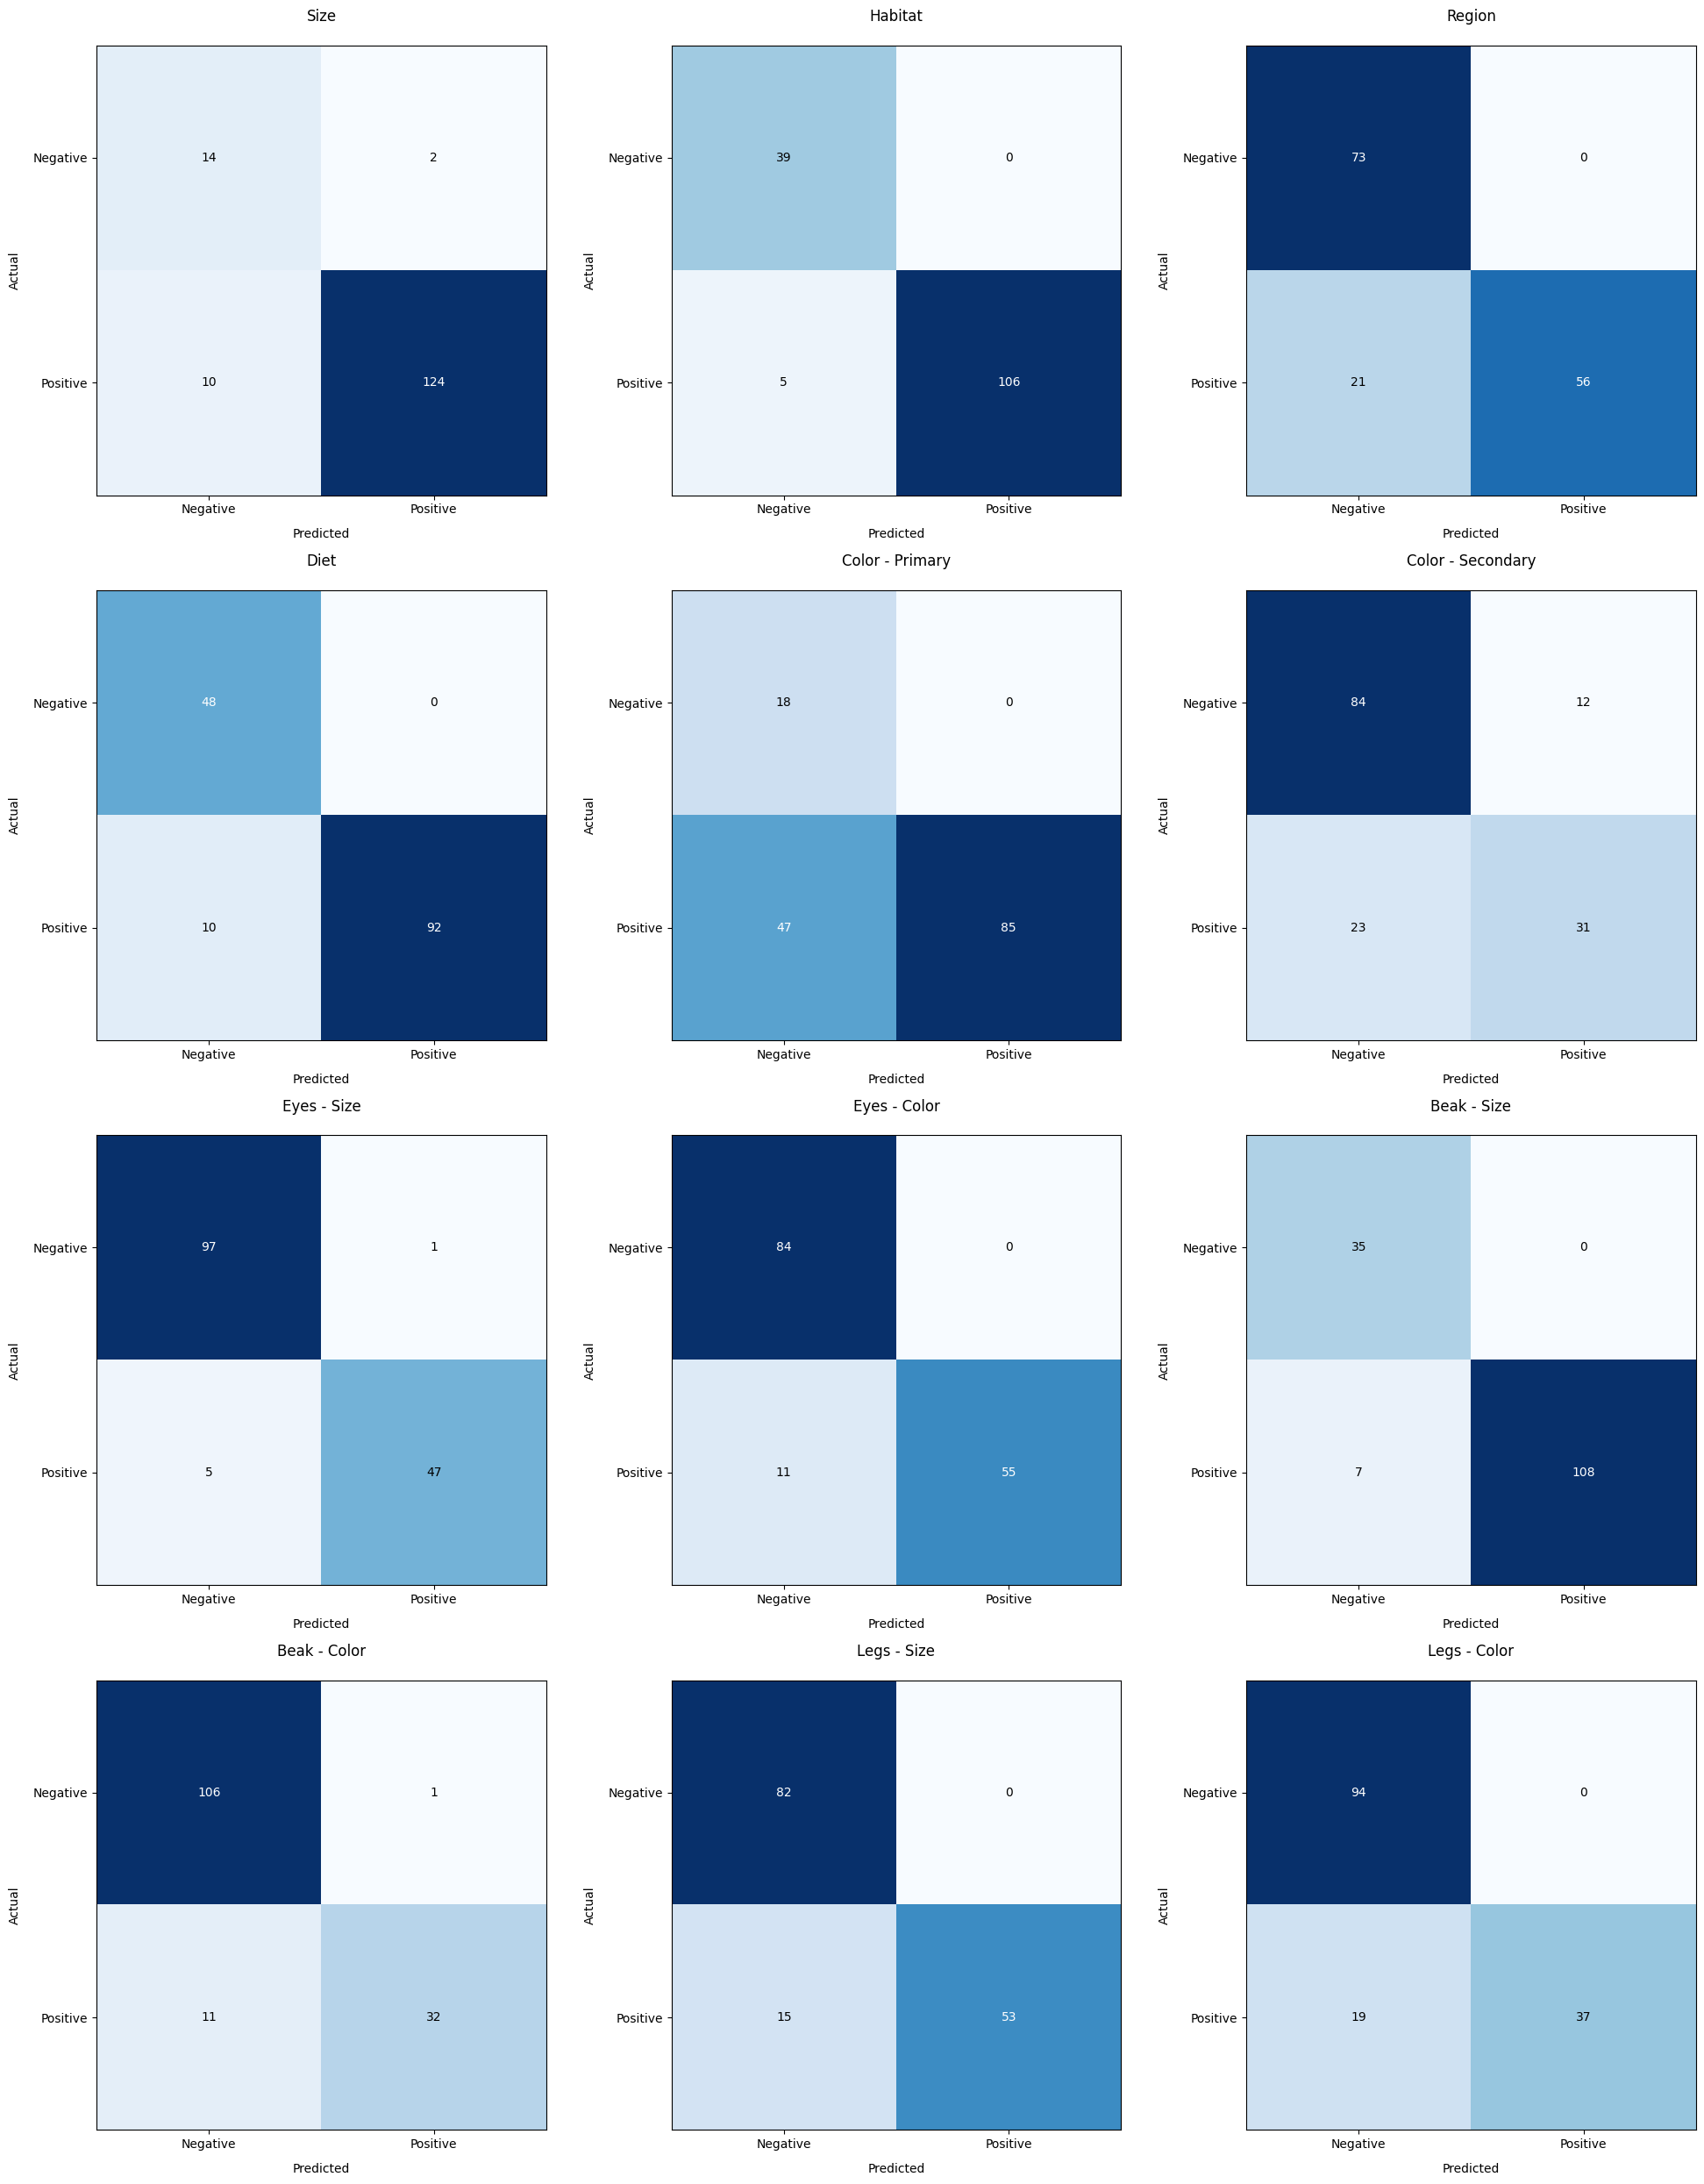

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrices(out_dict):
    # Collect all features and sub-features
    features_list = []

    # Top-level features (direct attributes)
    top_features = ['size', 'habitat', 'region', 'diet']
    for feat in top_features:
        features_list.append((feat, None, out_dict[feat]))

    # Nested features (sub-attributes)
    nested_features = {
        'color': ['primary', 'secondary'],
        'eyes': ['size', 'color'],
        'beak': ['size', 'color'],
        'legs': ['size', 'color']
    }
    for feat in nested_features:
        for sub in nested_features[feat]:
            metrics = out_dict[feat][sub]
            features_list.append((feat, sub, metrics))

    # Create subplots grid
    n_features = len(features_list)
    n_rows = 4  # Adjust based on your preference
    n_cols = 3  # 4x3 grid fits 12 subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 25))
    axes = axes.flatten()

    # Plot each confusion matrix
    for i, (feat, sub, metrics) in enumerate(features_list):
        ax = axes[i]
        title = f"{feat.capitalize()}" + (f" - {sub.capitalize()}" if sub else "")
        tn, fp, fn, tp = metrics['TN'], metrics['FP'], metrics['FN'], metrics['TP']

        # Create confusion matrix array
        cm = np.array([[tn, fp], [fn, tp]])

        # Plot heatmap
        im = ax.imshow(cm, cmap='Blues')
        ax.set_title(title, pad=20)
        ax.set_xlabel('Predicted', labelpad=10)
        ax.set_ylabel('Actual', labelpad=10)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Negative', 'Positive'])

        # Annotate values
        for i in range(2):
            for j in range(2):
                ax.text(j, i, cm[i, j], ha='center', va='center',
                        color='white' if cm[i, j] > cm.max()/2 else 'black')

    # Hide unused axes
    for j in range(n_features, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    # Save as JPEG
    plt.savefig("confusion_matrices.jpg", format='jpeg', dpi=300, bbox_inches='tight')

    plt.show()

# Generate evaluation results
result = advanced_evaluation()

# Plot the confusion matrices
plot_confusion_matrices(result)